In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib

In [2]:
data_NASDAQ  = yf.download('^IXIC', start='2010-01-01', end='2023-05-01')
data_NSE = yf.download('^NSEI', start='2010-01-01', end='2023-05-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<h3>Calculating Correlation Coefficient</h3>

In [3]:
df = pd.DataFrame()
df=pd.concat([data_NASDAQ['Adj Close'],data_NSE['Adj Close']],axis=1)
df.columns=['NASDAQ','NSE']
df.dropna(inplace=True)
corrcoeff = df['NASDAQ'].corr(df['NSE'])
print("Correlation Coefficient between NASDAQ and NSE is: ",corrcoeff)

Correlation Coefficient between NASDAQ and NSE is:  0.9513138758576779


The indidices are positively correlated and correlation is strong since the coefficient is high.

<h3>Lead Lag Relationship</h3>

In [4]:
lags = np.arange(-200,200,1)
lags
correlations = []
for lag in lags :
    shifted_nasdaq = df['NASDAQ'].shift(lag)
    correlation = df['NSE'].corr(shifted_nasdaq)
    correlations.append(correlation)

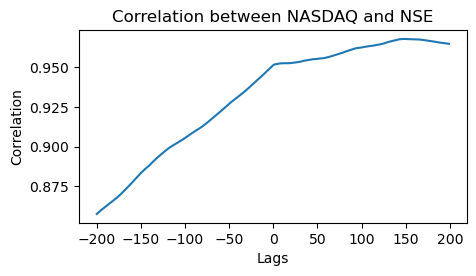

In [5]:
plt.figure(figsize=(5,2.5))
plt.plot(lags,correlations)
plt.title('Correlation between NASDAQ and NSE')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [6]:
max_correlation = max(correlations)
best_lag = lags[correlations.index(max_correlation)]
print("Best lag is: ",best_lag)
print("Max correlation is: ",max_correlation)

Best lag is:  148
Max correlation is:  0.9677174313611793


The best lag is 148. This means, when NSE was 148 days behind NASDAQ, the correlation between them was maximum. <br>
Therefore, NSE can act as a leading indicator for the movements of NASDAQ index.<br>
Hence we would choose NSE as the index for parameter optimization.<br>

<h3>Indicator Coding</h3>

<h4>1) Keltner Channel</h4>

In [7]:
def keltner_channel(data,atr_lookback=10,kc_lookback=20,multiplier=2):
    high = data['High']
    low = data['Low']
    close = data['Adj Close']
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower


<h4>2) Bollinger Bands</h4>

In [8]:
def bollinger_bands(data,lookback=20,multiplier=2):
    sma = data['Adj Close'].rolling(window=lookback).mean()
    high = data['High']
    low = data['Low']
    close = data['Adj Close']
    tp = pd.DataFrame((high+low+close)/3)
    sigma = tp.rolling(window=lookback).std()
    upper_band = sma + multiplier*sigma
    lower_band = sma - multiplier*sigma
    return upper_band,lower_band

<h4>3) MACD Indicator</h4>

In [9]:
def calc_macd(data,lower_window = 12,upper_window = 26,signal_window = 9):
    ema_12 = data['Adj Close'].ewm(span = lower_window,adjust = False).mean()
    ema_26 = data['Adj Close'].ewm(span = upper_window,adjust = False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span = signal_window,adjust = False).mean()
    return macd,signal_line

<h4>Strategies</h4>

In [10]:
def keltner_strategy(prices,kc_upper,kc_middle,kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

In [11]:
def bb_strategy(data, lower_bb, upper_bb):
    buy_price_bb = []
    sell_price_bb = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if i>0 and data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price_bb.append(data[i])
                sell_price_bb.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(np.nan)
                bb_signal.append(0)
        elif i>0 and data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price_bb.append(np.nan)
            sell_price_bb.append(np.nan)
            bb_signal.append(0)
            
    return buy_price_bb, sell_price_bb, bb_signal

In [12]:
def macd_strategy(data, macd, signal_line):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(macd)):
        if macd[i] > signal_line[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif macd[i] < signal_line[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

<h3>Parameter Optimization</h3>

In [13]:
parameter_ranges = {
    'kc_lookback': range(10, 30, 1),
    'bb_lookback': range(15, 30, 1),
    'macd_lowerwindow': range(10, 20, 1),
    'macd_upperwindow': range(25, 30, 1),
    'macd_signalwindow': range(5,10, 1)
}

<h4>Optimizing Keltner Channel</h4>

In [14]:
best_metric = float('-inf')
best_kc_lookback = None

for kc_lookback in parameter_ranges['kc_lookback']:
    upper_kc,middle_kc,lower_kc = keltner_channel(data_NSE,10,kc_lookback,2)
    buy_price_kc, sell_price_kc, kc_signal = keltner_strategy(data_NSE['Adj Close'], upper_kc, middle_kc, lower_kc)
    
    
    buy_kc=pd.DataFrame(buy_price_kc)
    buy_kc=buy_kc.fillna(0)
    buy_kc=buy_kc[~(buy_kc == 0).all(axis=1)]
    sell_kc=pd.DataFrame(sell_price_kc)
    sell_kc=sell_kc.fillna(0)
    sell_kc=sell_kc[~(sell_kc == 0).all(axis=1)]

    np1=np.array(buy_kc)
    np2=np.array(sell_kc)
    
    metric = ((np2[1:]-np1)/np1).max()*100
    if metric > best_metric:
        best_kc_lookback = kc_lookback
        best_metric = metric
print("Best KC Lookback period is:",best_kc_lookback)

Best KC Lookback period is: 19


<h4>Optimizing Bollinger Bands</h4>

In [15]:
best_metric = float('-inf')
best_bb_lookback = None

data = data_NSE.copy()

for bb_lookback in parameter_ranges['bb_lookback']:
    
    data['BB_MA'] = data['Close'].rolling(window=20).mean()
    data['BB_std'] = data['Close'].rolling(window=20).std()
    data['BB_UB'] = data['BB_MA'] + (2 * data['BB_std'])
    data['BB_LB'] = data['BB_MA'] - (2 * data['BB_std'])
    buy_price_bb, sell_price_bb, bb_signal = bb_strategy(data['Adj Close'], data['BB_UB'], data['BB_LB'])
    
    buy_price_bb=pd.DataFrame(buy_price_bb)
    buy_price_bb=buy_price_bb.fillna(0)
    buy_price_bb=buy_price_bb[~(buy_price_bb == 0).all(axis=1)]
    sell_price_bb=pd.DataFrame(sell_price_bb)
    sell_price_bb=sell_price_bb.fillna(0)
    sell_price_bb=sell_price_bb[~(sell_price_bb == 0).all(axis=1)]
    np_buy_bb=np.array(buy_price_bb)
    np_buy_bb = np_buy_bb[:-1]
    np_sell_bb=np.array(sell_price_bb)
    (np_sell_bb-np_buy_bb).mean() , (np_sell_bb-np_buy_bb).std()

    metric = ((np_sell_bb-np_buy_bb)/np_buy_bb).max()*100
    
    if metric > best_metric:
        best_bb_lookback = kc_lookback
        best_metric = metric
print("Best BB Lookback period is:",best_bb_lookback)

Best BB Lookback period is: 29


<h4>Optimizing MACD</h4>

In [16]:
best_metric = float('-inf')
best_macd_parameters = None

for macd_lowerwindow in parameter_ranges['macd_lowerwindow']:
    for macd_upperwindow in parameter_ranges['macd_upperwindow']:
        for macd_signalwindow in parameter_ranges['macd_signalwindow']:
            macd,signal_line = calc_macd(data_NSE,macd_lowerwindow,macd_upperwindow,macd_signalwindow)
            buy_price_macd, sell_price_macd, macd_signal = macd_strategy(data_NSE['Adj Close'], macd, signal_line)

            buy_macd=pd.DataFrame(buy_price_macd)
            buy_macd=buy_macd.fillna(0)
            buy_macd=buy_macd[~(buy_macd == 0).all(axis=1)]
            sell_macd=pd.DataFrame(sell_price_macd)
            sell_macd=sell_macd.fillna(0)
            sell_macd=sell_macd[~(sell_macd == 0).all(axis=1)]

            np1=np.array(buy_macd)
            np2=np.array(sell_macd)

            metric = ((np2[-1:]-np1)/np1).max()*100
            if metric > best_metric:
                best_macd_parameters = {
                    'macd_lowerwindow': 10,
                    'macd_upperwindow': 26,
                    'macd_signalwindow': 7
                }
                best_metric = metric

print("Best MACD parameters are:",best_macd_parameters)


Best MACD parameters are: {'macd_lowerwindow': 10, 'macd_upperwindow': 26, 'macd_signalwindow': 7}


<b>Judging the performance with optimised parameters<b>

In [17]:
def sharpe_ratio(data, risk_free_rate=0):
    mean_daily_return = data.mean()
    sigma = data.std()
    return (mean_daily_return/sigma)

In [18]:
def sortino_ratio(data):
    mean_return = data.mean()
    std_neg = data[data<0].std()
    return mean_return/std_neg

<h4>Keltner Channel:</h4>

In [19]:
upper_kc,middle_kc,lower_kc = keltner_channel(data_NASDAQ,10,best_kc_lookback,2)
buy_price_kc, sell_price_kc, kc_signal = keltner_strategy(data_NASDAQ['Adj Close'], upper_kc, middle_kc, lower_kc)


buy_kc=pd.DataFrame(buy_price_kc)
buy_kc=buy_kc.fillna(0)
buy_kc=buy_kc[~(buy_kc == 0).all(axis=1)]
sell_kc=pd.DataFrame(sell_price_kc)
sell_kc=sell_kc.fillna(0)
sell_kc=sell_kc[~(sell_kc == 0).all(axis=1)]

np1=np.array(buy_kc)
np2=np.array(sell_kc)


print("Sharpe Ratio:", sharpe_ratio(np2[1:]-np1))
print("Sortino Ratio:", sortino_ratio(np2[1:]-np1))
print("Maximum Drawdown:",(np1-np2[1:]).min()/np2[18,0]*100,"%")
print("Cummulative Returns:",((np2[1:]-np1)/np1).max()*100,"%")

Sharpe Ratio: 0.5720954314994258
Sortino Ratio: 0.4621881470848919
Maximum Drawdown: -21.357063711410454 %
Cummulative Returns: 14.214219717461923 %


<h4>Bollinger Bands: </h4>

In [20]:
data = data_NASDAQ.copy()
    
data['BB_MA'] = data['Close'].rolling(window=best_bb_lookback).mean()
data['BB_std'] = data['Close'].rolling(window=best_bb_lookback).std()
data['BB_UB'] = data['BB_MA'] + (2 * data['BB_std'])
data['BB_LB'] = data['BB_MA'] - (2 * data['BB_std'])
buy_price_bb, sell_price_bb, bb_signal = bb_strategy(data['Adj Close'], data['BB_UB'], data['BB_LB'])

buy_price_bb=pd.DataFrame(buy_price_bb)
buy_price_bb=buy_price_bb.fillna(0)
buy_price_bb=buy_price_bb[~(buy_price_bb == 0).all(axis=1)]
sell_price_bb=pd.DataFrame(sell_price_bb)
sell_price_bb=sell_price_bb.fillna(0)
sell_price_bb=sell_price_bb[~(sell_price_bb == 0).all(axis=1)]
np1=np.array(buy_price_bb)
np1 = np1[:-1]
np2=np.array(sell_price_bb)

print("Sharpe Ratio:", sharpe_ratio(np2-np1))
print("Sortino Ratio:", sortino_ratio(np2-np1))
print("Maximum Drawdown:",(np1-np2).min()/np2[18,0]*100,"%")
print("Cummulative Returns:",((np2-np1)/np1).max()*100,"%")


Sharpe Ratio: 0.10599231676688117
Sortino Ratio: 0.17936074644026098
Maximum Drawdown: -33.03054189399041 %
Cummulative Returns: 29.80183740424463 %


<h4>MACD:</h4>

In [21]:
data_NASDAQ=data_NASDAQ.iloc[:-1,:]

In [22]:
macd,signal_line = calc_macd(data_NASDAQ,best_macd_parameters['macd_lowerwindow'],best_macd_parameters['macd_upperwindow'],best_macd_parameters['macd_signalwindow'])
buy_price_macd, sell_price_macd, macd_signal = macd_strategy(data_NASDAQ['Adj Close'], macd, signal_line)

buy_macd=pd.DataFrame(buy_price_macd)
buy_macd=buy_macd.fillna(0)
buy_macd=buy_macd[~(buy_macd == 0).all(axis=1)]
sell_macd=pd.DataFrame(sell_price_macd)
sell_macd=sell_macd.fillna(0)
sell_macd=sell_macd[~(sell_macd == 0).all(axis=1)]

np1=np.array(buy_macd)
np2=np.array(sell_macd)

print("Sharpe Ratio:", sharpe_ratio(np2[-1:]-np1))
print("Sortino Ratio:", sortino_ratio(np2[-1:]-np1))
print("Maximum Drawdown:",(np1-np2[-1:]).min()/np2[18,0]*100,"%")
print("Cummulative Returns:",((np2[-1:]-np1)/np1).max()*100,"%")

Sharpe Ratio: 1.5136133572124193
Sortino Ratio: 5.911496249813764
Maximum Drawdown: -352.1582173120418 %
Cummulative Returns: 447.86835392851697 %


<h3>Signal Generation</h3>

<h4>1) Keltner Channel</h4>

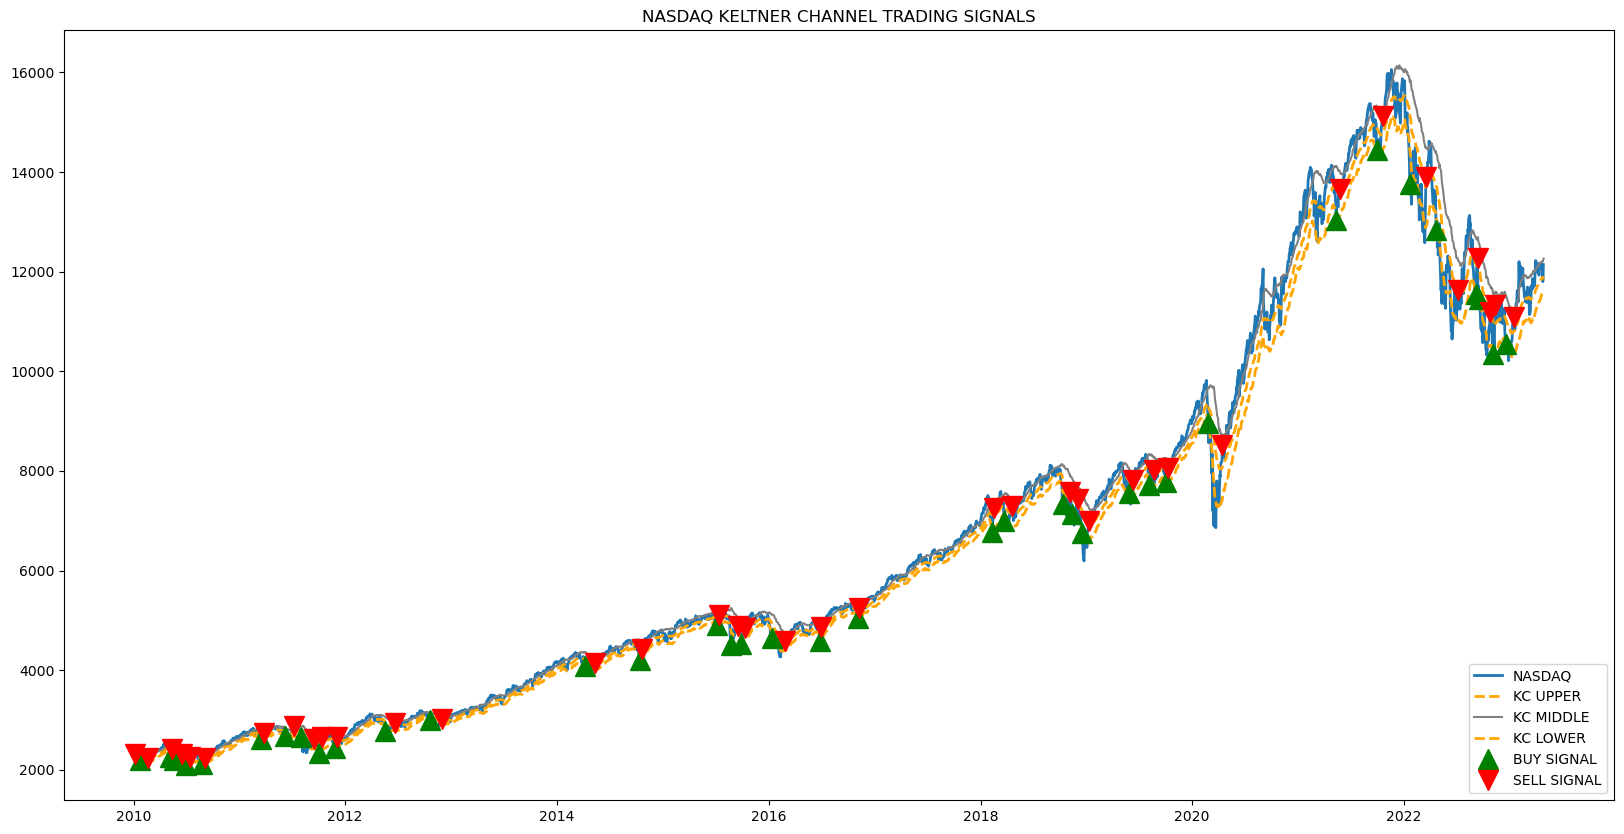

In [23]:
plt.figure(figsize=(20,10))
plt.plot(data_NASDAQ['Adj Close'], linewidth = 2, label = 'NASDAQ')
plt.plot(upper_kc, linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER')
plt.plot(middle_kc, linewidth = 1.5, color = 'grey', label = 'KC MIDDLE')
plt.plot(lower_kc, linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER')
plt.plot(data_NASDAQ.index, buy_price_kc, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data_NASDAQ.index, sell_price_kc, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('NASDAQ KELTNER CHANNEL TRADING SIGNALS')
plt.show()

<h4>2) Bollinger Bands</h4>

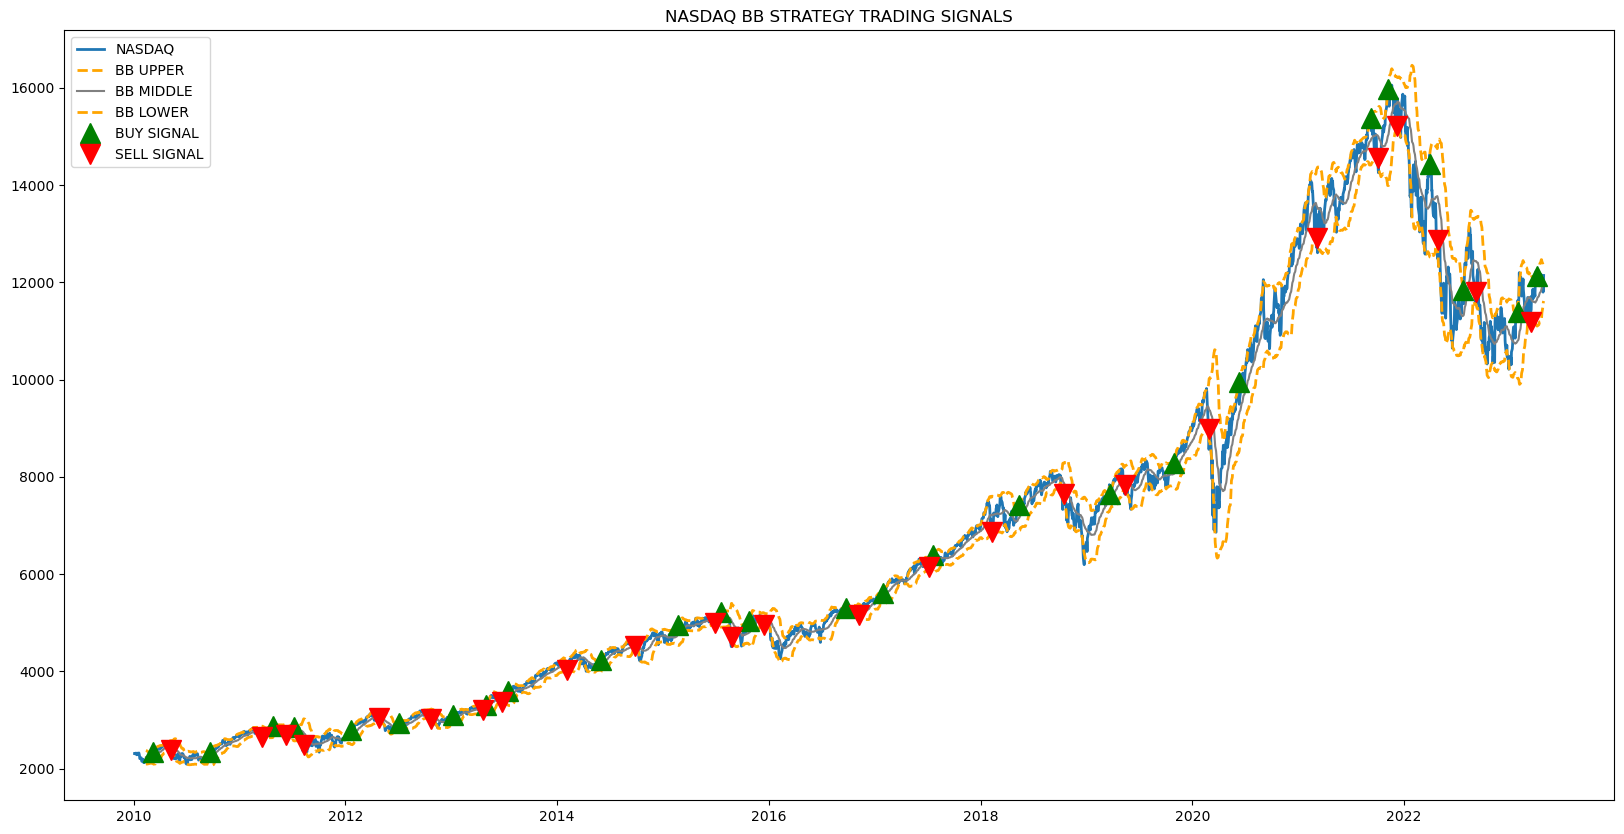

In [24]:
data = data_NASDAQ.copy()
    
data['BB_MA'] = data['Close'].rolling(window=best_bb_lookback).mean()
data['BB_std'] = data['Close'].rolling(window=best_bb_lookback).std()
data['BB_UB'] = data['BB_MA'] + (2 * data['BB_std'])
data['BB_LB'] = data['BB_MA'] - (2 * data['BB_std'])
buy_price_bb, sell_price_bb, bb_signal = bb_strategy(data['Adj Close'], data['BB_UB'], data['BB_LB'])

plt.figure(figsize=(20,10))
plt.plot(data['Adj Close'], linewidth = 2, label = 'NASDAQ')
plt.plot(data['BB_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'BB UPPER')
plt.plot(data['BB_MA'], linewidth = 1.5, color = 'grey', label = 'BB MIDDLE')
plt.plot(data['BB_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'BB LOWER')
plt.plot(data.index, buy_price_bb, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price_bb, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('NASDAQ BB STRATEGY TRADING SIGNALS')
plt.show()

<h4>3) MACD</h4>

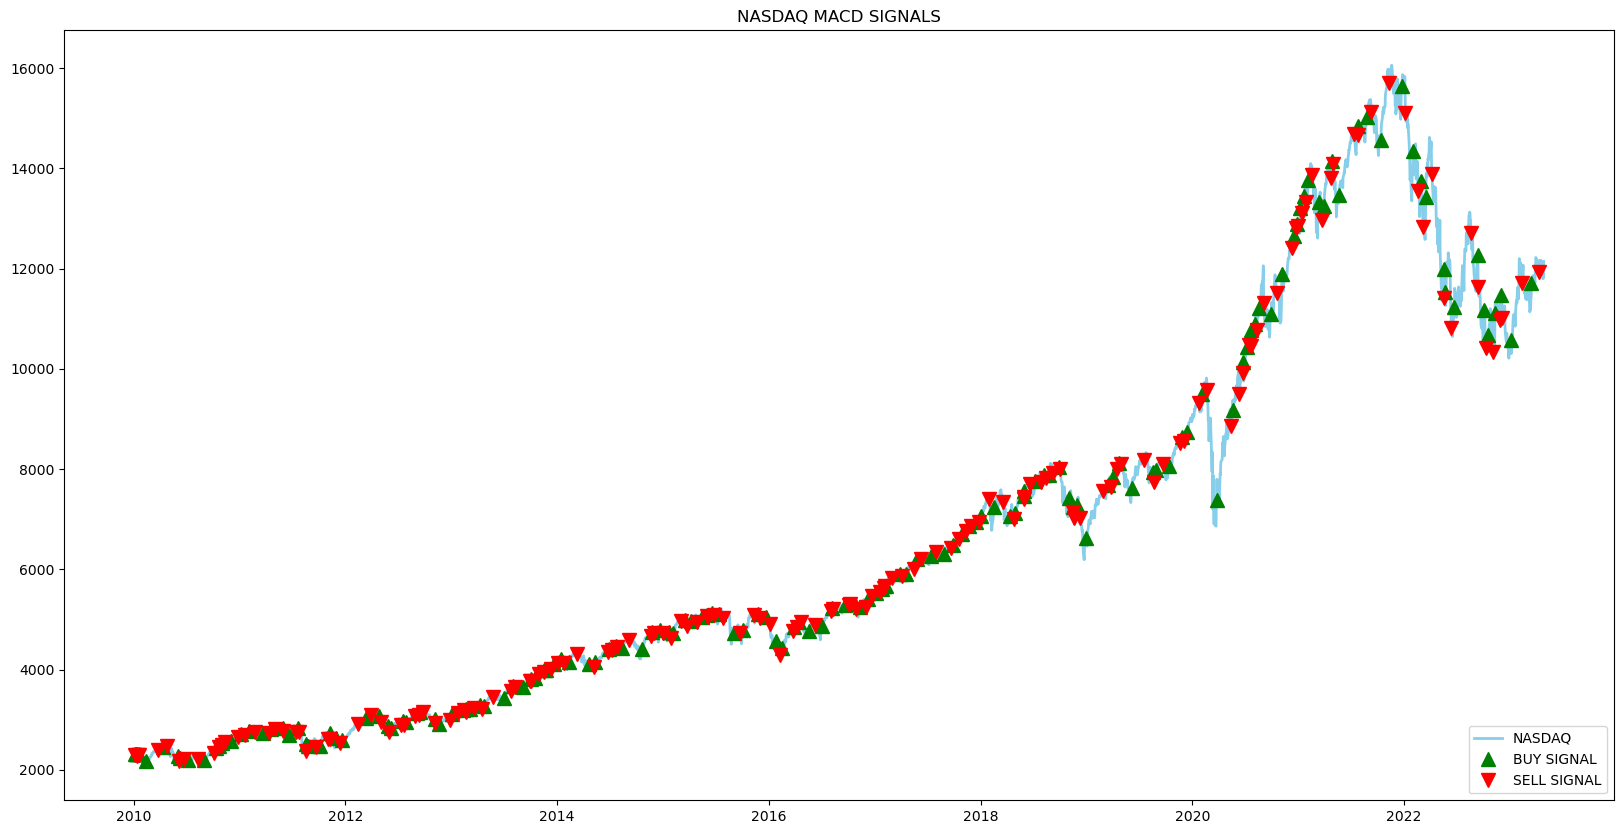

In [25]:
plt.figure(figsize=(20,10))
plt.plot(data_NASDAQ['Adj Close'], color = 'skyblue', linewidth = 2, label = 'NASDAQ')
plt.plot(data_NASDAQ.index, buy_price_macd, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
plt.plot(data_NASDAQ.index, sell_price_macd, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
plt.legend()
plt.title('NASDAQ MACD SIGNALS')        
plt.legend(loc = 'lower right')
plt.show()